In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns
from tqdm import tqdm
from itertools import product


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

## Data

### Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(
    impute_missing=True, countries=countries
)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"],
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [3]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

### Random Forest - possible feature combinations

In [24]:
tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

### TRAINING
lags_default = [1, 2, 3, 4, 5, 6]

alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}

sub_model_names = [
    "bench-rw-realistic",
    "19+gdp+unempl",
    "ar+gdp+unempl",
    "ar+19+gdp+unempl",
]

steps_ahead = (1, 2, 3, 4)

model_names = product(steps_ahead, sub_model_names)
model_names = ["_".join([str(s) for s in x]) for x in model_names]

feature_combinations = [
    ["value"],
    ["19", "gdp", "unempl"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
]

use_linear_dummy = [True, False, False, False]

linear_dummy_default_lag = 2

# params = {}
params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8, 16],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16, 32],
}


for step in tqdm(steps_ahead):

    for i, features in enumerate(tqdm(feature_combinations)):

        # remove non-permissible lags
        if use_linear_dummy[i]:
            lags = [linear_dummy_default_lag + step - 1]
            alternate_lags = {}
        else:
            lags = lags_default[step - 1 :]
            alternate_lags = {
                k: v[step - 1 :] for k, v in alternate_lags_default.items()
            }

        labeled = eumf_pipeline.prepare_data(
            panel_comb_3m_macro,
            columns=features,
            lags=lags,
            alternate_lags=alternate_lags,
            t_min=T_MIN,
            t_max=T_MAX,
        )
        transformed = eumf_pipeline.transform_data(labeled)
        train, test = eumf_pipeline.split_data(
            transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
        )
        train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

        train_stackeds.append(train_stacked)
        train_unstackeds.append(train)
        test_stackeds.append(test_stacked)

        if use_linear_dummy[i]:
            tuner = None
            estimator = eumf_custom_models.make_linear_dummy_model(
                train_stacked, features=[features[0] + "_" + str(lags[0])],
            )
        else:
            tuner = eumf_pipeline.train_reg_model(
                train_stacked,
                reg=ensemble.RandomForestRegressor(random_state=42),
                extra_pipeline_steps=[preprocessing.StandardScaler()],
                params=params,
                scoring=eumf_eval.scorer_rmse,
                # dummy_encoder="drop",
            )
            estimator = tuner.best_estimator_
        tuners.append(tuner)
        estimators.append(estimator)

        cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
        cv_scores.append(cv_score)

        test_score = eumf_eval.score_test(estimator, test_stacked,)
        test_scores.append(test_score)


100%|██████████| 4/4 [03:50<00:00, 57.63s/it]


In [25]:
pd.DataFrame(
    {k: t.best_params_ for k, t in zip(model_names, tuners) if t is not None}
).transpose()



,randomforestregressor__max_features,randomforestregressor__min_samples_leaf,randomforestregressor__min_samples_split
1_19+gdp+unempl,sqrt,2,2
1_ar+gdp+unempl,auto,8,2
1_ar+19+gdp+unempl,auto,16,2
2_19+gdp+unempl,sqrt,2,16
2_ar+gdp+unempl,auto,16,2
2_ar+19+gdp+unempl,sqrt,2,16
3_19+gdp+unempl,sqrt,1,8
3_ar+gdp+unempl,sqrt,16,2
3_ar+19+gdp+unempl,auto,16,2
4_19+gdp+unempl,sqrt,2,32


In [26]:
df_cv_results = eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)
df_cv_results_complete = pd.concat(cv_scores)
df_cv_results


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                       mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
1_bench-rw-realistic   0.003   5.655e-04  1.999e-04    0.004    5.381e-04  1.903e-04  -0.092   0.020  0.007   -0.139   0.047  0.017           0.107          0.201  0.071     0.231    0.305  0.108      0.034      0.056  0.020
1_19+gdp+unempl        0.123   4.762e-03  1.684e-03    0.011    8.660e-04  3.062e-04  -0.095   0.036  0.013   -0.136   0.056  0.020           0.191          0.164  0.058     0.322    0.245  0.087      0.032      0.041  0.015
1_ar+gdp+unempl        0.231   1.002e-02  3.544e-03    0.011    1.106e-03  3.910e-04  -0.090   0.028  0.010   -0.129   0.049  0.017           0.265          0.107  0.038     0.380    0.207  0.073      0.037      0.046  0.016
1_ar+19+gdp+unempl     0.237   1.381e-02  4.881e-03    0.011    9.649e-04  3.411e-04  -0.086   0.028  0.010   -0.125   0.049  0.017           0.311          0.128  0.045     0.422    0.203  0.072      0.041      0.048  0.017
2_bench-rw-realistic   0.004   1.227e-03  4.337e-04    0.004    6.730e-04  2.379e-04  -0.113   0.034  0.012   -0.168   0.059  0.021          -0.221          0.323  0.114    -0.103    0.477  0.169      0.013      0.045  0.016
2_19+gdp+unempl        0.125   1.690e-02  5.976e-03    0.012    2.607e-03  9.218e-04  -0.100   0.039  0.014   -0.141   0.060  0.021           0.168          0.122  0.043     0.287    0.221  0.078      0.026      0.039  0.014
2_ar+gdp+unempl        0.156   1.050e-02  3.712e-03    0.010    7.823e-04  2.766e-04  -0.103   0.038  0.014   -0.144   0.061  0.022           0.171          0.141  0.050     0.257    0.249  0.088      0.024      0.042  0.015
2_ar+19+gdp+unempl     0.106   3.534e-03  1.250e-03    0.010    7.314e-04  2.586e-04  -0.099   0.038  0.013   -0.140   0.060  0.021           0.195          0.154  0.054     0.291    0.245  0.087      0.028      0.041  0.015
3_bench-rw-realistic   0.002   4.879e-04  1.725e-04    0.003    4.701e-04  1.662e-04  -0.140   0.039  0.014   -0.203   0.061  0.022          -0.951          0.942  0.333    -0.804    1.205  0.426     -0.013      0.043  0.015
3_19+gdp+unempl        0.109   5.592e-03  1.977e-03    0.010    5.281e-04  1.867e-04  -0.105   0.043  0.015   -0.149   0.066  0.023           0.102          0.160  0.057     0.238    0.212  0.075      0.022      0.034  0.012
3_ar+gdp+unempl        0.095   1.842e-02  6.513e-03    0.010    8.878e-04  3.139e-04  -0.113   0.045  0.016   -0.156   0.065  0.023           0.104          0.089  0.031     0.140    0.243  0.086      0.014      0.036  0.013
3_ar+19+gdp+unempl     0.162   9.205e-03  3.254e-03    0.010    5.797e-04  2.049e-04  -0.106   0.039  0.014   -0.148   0.061  0.022           0.105          0.159  0.056     0.199    0.286  0.101      0.021      0.042  0.015
4_bench-rw-realistic   0.002   8.108e-05  2.867e-05    0.003    1.261e-04  4.457e-05  -0.149   0.044  0.016   -0.209   0.067  0.024          -0.960          1.012  0.358    -0.919    1.357  0.480     -0.022      0.042  0.015
4_19+gdp+unempl        0.115   2.502e-02  8.846e-03    0.013    3.337e-03  1.180e-03  -0.111   0.045  0.016   -0.154   0.067  0.024           0.081          0.089  0.031     0.175    0.212  0.075      0.015      0.033  0.012
4_ar+gdp+unempl        0.099   9.987e-03  3.531e-03    0.011    8.783e-04  3.105e-04  -0.118   0.050  0.018   -0.163   0.073  0.026           0.065          0.088  0.031     0.102    0.222  0.079      0.009      0.030  0.011
4_ar+19+gdp+unempl     0.118   1.199e-02  4.237e-03    0.012    7.631e-04  2.698e-04  -0.112   0.045  0.016   -0.156   0.068  0.024           0.074          0.110  0.039     0.163    0.230  0.081 

In [27]:
df_holdout_results = eumf_eval.agg_multiple_test_scores(test_scores, model_names)
df_holdout_results


,mae,rmse,explained_variance,r2_mod,delta_mae
1_bench-rw-realistic,-0.068,-0.094,-0.031,0.069,2.072e-03
1_19+gdp+unempl,-0.069,-0.094,-0.036,0.063,1.028e-03
1_ar+gdp+unempl,-0.069,-0.093,-0.011,0.091,1.504e-03
1_ar+19+gdp+unempl,-0.067,-0.092,0.030,0.109,2.857e-03
2_bench-rw-realistic,-0.074,-0.093,0.184,0.084,-3.788e-03
2_19+gdp+unempl,-0.068,-0.095,-0.045,0.050,2.131e-03
2_ar+gdp+unempl,-0.067,-0.087,0.151,0.196,3.161e-03
2_ar+19+gdp+unempl,-0.065,-0.090,0.092,0.147,5.185e-03
3_bench-rw-realistic,-0.086,-0.114,-0.416,-0.367,-1.601e-02
3_19+gdp+unempl,-0.069,-0.092,0.058,0.116,1.658e-03


In [28]:
df_cv_results


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                       mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
1_bench-rw-realistic   0.003   5.655e-04  1.999e-04    0.004    5.381e-04  1.903e-04  -0.092   0.020  0.007   -0.139   0.047  0.017           0.107          0.201  0.071     0.231    0.305  0.108      0.034      0.056  0.020
1_19+gdp+unempl        0.123   4.762e-03  1.684e-03    0.011    8.660e-04  3.062e-04  -0.095   0.036  0.013   -0.136   0.056  0.020           0.191          0.164  0.058     0.322    0.245  0.087      0.032      0.041  0.015
1_ar+gdp+unempl        0.231   1.002e-02  3.544e-03    0.011    1.106e-03  3.910e-04  -0.090   0.028  0.010   -0.129   0.049  0.017           0.265          0.107  0.038     0.380    0.207  0.073      0.037      0.046  0.016
1_ar+19+gdp+unempl     0.237   1.381e-02  4.881e-03    0.011    9.649e-04  3.411e-04  -0.086   0.028  0.010   -0.125   0.049  0.017           0.311          0.128  0.045     0.422    0.203  0.072      0.041      0.048  0.017
2_bench-rw-realistic   0.004   1.227e-03  4.337e-04    0.004    6.730e-04  2.379e-04  -0.113   0.034  0.012   -0.168   0.059  0.021          -0.221          0.323  0.114    -0.103    0.477  0.169      0.013      0.045  0.016
2_19+gdp+unempl        0.125   1.690e-02  5.976e-03    0.012    2.607e-03  9.218e-04  -0.100   0.039  0.014   -0.141   0.060  0.021           0.168          0.122  0.043     0.287    0.221  0.078      0.026      0.039  0.014
2_ar+gdp+unempl        0.156   1.050e-02  3.712e-03    0.010    7.823e-04  2.766e-04  -0.103   0.038  0.014   -0.144   0.061  0.022           0.171          0.141  0.050     0.257    0.249  0.088      0.024      0.042  0.015
2_ar+19+gdp+unempl     0.106   3.534e-03  1.250e-03    0.010    7.314e-04  2.586e-04  -0.099   0.038  0.013   -0.140   0.060  0.021           0.195          0.154  0.054     0.291    0.245  0.087      0.028      0.041  0.015
3_bench-rw-realistic   0.002   4.879e-04  1.725e-04    0.003    4.701e-04  1.662e-04  -0.140   0.039  0.014   -0.203   0.061  0.022          -0.951          0.942  0.333    -0.804    1.205  0.426     -0.013      0.043  0.015
3_19+gdp+unempl        0.109   5.592e-03  1.977e-03    0.010    5.281e-04  1.867e-04  -0.105   0.043  0.015   -0.149   0.066  0.023           0.102          0.160  0.057     0.238    0.212  0.075      0.022      0.034  0.012
3_ar+gdp+unempl        0.095   1.842e-02  6.513e-03    0.010    8.878e-04  3.139e-04  -0.113   0.045  0.016   -0.156   0.065  0.023           0.104          0.089  0.031     0.140    0.243  0.086      0.014      0.036  0.013
3_ar+19+gdp+unempl     0.162   9.205e-03  3.254e-03    0.010    5.797e-04  2.049e-04  -0.106   0.039  0.014   -0.148   0.061  0.022           0.105          0.159  0.056     0.199    0.286  0.101      0.021      0.042  0.015
4_bench-rw-realistic   0.002   8.108e-05  2.867e-05    0.003    1.261e-04  4.457e-05  -0.149   0.044  0.016   -0.209   0.067  0.024          -0.960          1.012  0.358    -0.919    1.357  0.480     -0.022      0.042  0.015
4_19+gdp+unempl        0.115   2.502e-02  8.846e-03    0.013    3.337e-03  1.180e-03  -0.111   0.045  0.016   -0.154   0.067  0.024           0.081          0.089  0.031     0.175    0.212  0.075      0.015      0.033  0.012
4_ar+gdp+unempl        0.099   9.987e-03  3.531e-03    0.011    8.783e-04  3.105e-04  -0.118   0.050  0.018   -0.163   0.073  0.026           0.065          0.088  0.031     0.102    0.222  0.079      0.009      0.030  0.011
4_ar+19+gdp+unempl     0.118   1.199e-02  4.237e-03    0.012    7.631e-04  2.698e-04  -0.112   0.045  0.016   -0.156   0.068  0.024           0.074          0.110  0.039     0.163    0.230  0.081 

In [29]:
df_cv_results_complete


,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod,test_delta_mae
0,0.003,0.005,-0.110,-0.167,3.128e-01,7.314e-01,1.512e-01
1,0.004,0.004,-0.116,-0.173,3.475e-01,5.661e-01,7.881e-02
2,0.003,0.003,-0.096,-0.190,5.245e-02,2.667e-01,3.132e-02
3,0.002,0.004,-0.109,-0.192,3.480e-01,3.763e-01,3.349e-02
4,0.003,0.003,-0.078,-0.100,-1.103e-02,-1.494e-04,-5.725e-03
5,0.003,0.003,-0.096,-0.126,-9.404e-02,-8.180e-02,-2.598e-03
6,0.003,0.004,-0.080,-0.100,-1.423e-01,-4.973e-02,-8.569e-03
7,0.002,0.003,-0.055,-0.069,4.123e-02,4.053e-02,-3.371e-03
0,0.129,0.012,-0.154,-0.208,1.932e-02,5.841e-01,1.071e-01
1,0.126,0.010,-0.109,-0.144,4.238e-01,6.989e-01,8.600e-02


In [30]:
sub_model_names_long = sub_model_names * len(steps_ahead)
steps_ahead_long = [
    x for sub in [[s] * len(sub_model_names) for s in steps_ahead] for x in sub
]

df_cv_results["model"] = sub_model_names_long
df_cv_results["step"] = steps_ahead_long
df_holdout_results["model"] = sub_model_names_long
df_holdout_results["step"] = steps_ahead_long

df_cv_results_complete = pd.concat(
    [
        df.assign(**{"model": sub_model_names_long[i], "step": steps_ahead_long[i]})
        for i, df in enumerate(cv_scores)
    ]
).reset_index()


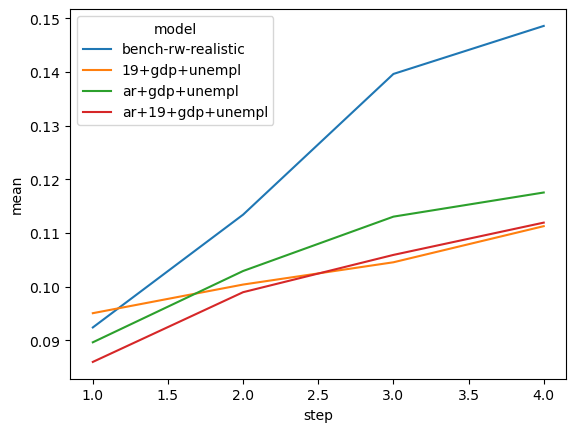

In [31]:
sns.lineplot(
    data=df_cv_results, y=-df_cv_results["test_mae"]["mean"], hue="model", x="step"
)
plt.show()


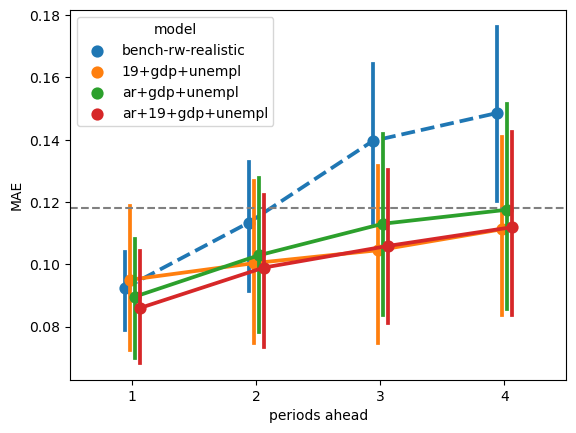

In [32]:
ax = sns.pointplot(
    data=df_cv_results_complete,
    y=-df_cv_results_complete["test_mae"],
    hue="model",
    # style="model",
    x="step",
    dodge=0.12,
    # ci=68,
    linestyles=["--", "-", "-", "-"]
    # markers=True,
)
# ax = sns.lineplot(
#     data=df_cv_results_complete,
#     y=-df_cv_results_complete["test_mae"],
#     hue="model",
#     style="model",
#     x="step",
#     # dodge=True,
#     ci=68,
#     markers=True,
# )
plt.axhline(0.118, c="grey", ls="--")
# plt.setp(ax.collections[0], alpha=0.1)
# plt.setp(ax.collections[1], alpha=0.1)
# plt.setp(ax.collections[2], alpha=0.1)
# plt.setp(ax.collections[3], alpha=0.1)
plt.ylabel("MAE")
plt.xlabel("periods ahead")
plt.show()


In [33]:
cv_scores[0].assign(**{"model": 0})



,fit_time,score_time,test_mae,test_rmse,test_explained_variance,test_r2_mod,test_delta_mae,model
0,0.003,0.005,-0.110,-0.167,0.313,7.314e-01,0.151,0
1,0.004,0.004,-0.116,-0.173,0.347,5.661e-01,0.079,0
2,0.003,0.003,-0.096,-0.190,0.052,2.667e-01,0.031,0
3,0.002,0.004,-0.109,-0.192,0.348,3.763e-01,0.033,0
4,0.003,0.003,-0.078,-0.100,-0.011,-1.494e-04,-0.006,0
5,0.003,0.003,-0.096,-0.126,-0.094,-8.180e-02,-0.003,0
6,0.003,0.004,-0.080,-0.100,-0.142,-4.973e-02,-0.009,0
7,0.002,0.003,-0.055,-0.069,0.041,4.053e-02,-0.003,0
